In [ ]:
!pip install numpy pandas scikit-learn xgboost matplotlib seaborn plotly

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

In [ ]:
# Standard amino acids (excluding B,J,O,U,X,Z as per paper)
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def generate_synthetic_peptides(num_samples=1000, seq_length=15):
    peptides = []
    labels = []

    for _ in range(num_samples):
        # Generate random peptide
        peptide = ''.join(np.random.choice(amino_acids, size=seq_length))
        peptides.append(peptide)

        # Synthetic label based on some rules (simplified)
        y_count = peptide.count('Y')
        if y_count >= 3 and np.random.random() > 0.7:
            labels.append(1)  # B3P2
        else:
            labels.append(0)  # non-B3P2

    return peptides, np.array(labels)

# Generate data
peptides, labels = generate_synthetic_peptides(1000)

# Calculate features
def calculate_features(peptides):
    features = []
    for pep in peptides:
        # Amino acid composition of Tyrosine (Y)
        aac_y = pep.count('Y') / len(pep)

        # Simplified pI calculation (random normal around 8.5 for B3P2-like)
        if np.random.random() > 0.7:
            pl = np.random.normal(8.5, 0.5)
        else:
            pl = np.random.normal(6.5, 1.5)

        # Simplified molecular weight (random normal)
        mw = np.random.normal(1500, 300)

        features.append([aac_y, pl, mw])

    return np.array(features)

X = calculate_features(peptides)
y = labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.97
F1 Score: 0.00
AUC: 0.98


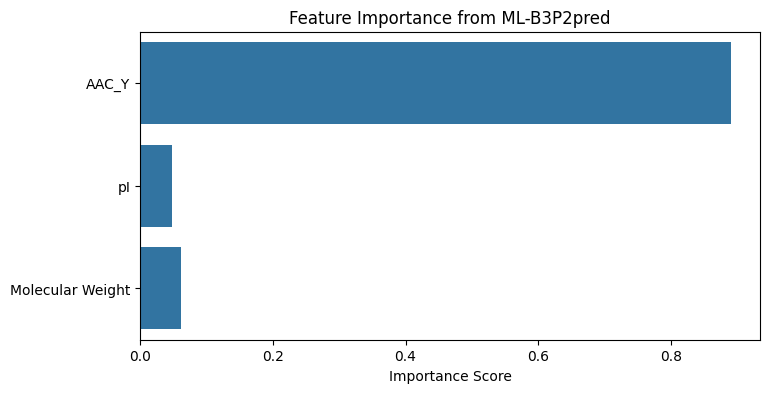

In [ ]:
# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Feature importance
feature_names = ['AAC_Y', 'pI', 'Molecular Weight']
importance = model.feature_importances_

plt.figure(figsize=(8, 4))
sns.barplot(x=importance, y=feature_names)
plt.title('Feature Importance from ML-B3P2pred')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
class HyGSA:
    def __init__(self, model, num_particles=50, max_iter=100, g0=100, alpha=0.5, beta=0.3, gamma=0.15, delta=0.05):
        self.model = model  # ML-B3P2pred model
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.g0 = g0  # initial gravitational constant
        self.alpha = alpha  # weights for fitness function
        self.beta = beta
        self.gamma = gamma
        self.delta = delta

    def initialize_population(self, seq_length=15):
        """Initialize population with random peptides"""
        self.population = []
        for _ in range(self.num_particles):
            peptide = ''.join(np.random.choice(amino_acids, size=seq_length))
            self.population.append(peptide)

    def calculate_fitness(self, peptide):
        """Calculate fitness for a peptide"""
        # Calculate features
        aac_y = peptide.count('Y') / len(peptide)
        pl = np.random.normal(8.5, 0.5) if aac_y > 0.2 else np.random.normal(6.5, 1.5)
        mw = np.random.normal(1500, 300)

        # Get PPV from model
        features = np.array([[aac_y, pl, mw]])
        ppv = self.model.predict_proba(features)[0, 1]

        # Normalize features
        npI = (pl - 4) / (10 - 4)  # assuming pI range 4-10
        nmw = (mw - 500) / (3000 - 500)  # assuming MW range 500-3000

        # Calculate fitness (minimization problem)
        fitness = 1 - self.delta*(1 - nmw) - (self.alpha*ppv + self.beta*aac_y + self.gamma*npI)
        return fitness, ppv, aac_y, npI, nmw

    def sample_population(self, fitness_values):
        """Sample population using subset-sum inspired method"""
        N = len(self.population)
        sample_size = int(2 * N / 3)
        cum_fit = sum(fitness_values)

        # Step 1: Random selection based on fitness
        sample_pop = []
        sum_fit = 0
        r1 = np.random.uniform(cum_fit/2, cum_fit)

        while len(sample_pop) < sample_size // 2:
            idx = np.random.randint(0, N)
            if idx not in [i for i, _ in sample_pop]:
                sample_pop.append((idx, fitness_values[idx]))
                sum_fit += fitness_values[idx]
                if sum_fit > r1:
                    break

        # Step 2: Statistical selection
        remaining = [i for i in range(N) if i not in [idx for idx, _ in sample_pop]]
        mu = np.mean(fitness_values)
        sigma = np.std(fitness_values)

        # Categorize remaining particles
        pop1 = [i for i in remaining if fitness_values[i] < mu - sigma]
        pop2 = [i for i in remaining if mu - sigma <= fitness_values[i] <= mu + sigma]
        pop3 = [i for i in remaining if fitness_values[i] > mu + sigma]

        # Add particles to balance the sample
        needed = sample_size - len(sample_pop)

        if len(sample_pop) < sample_size // 3:
            # Need more low-fitness particles
            add_from = pop1 + pop2 + pop3
        else:
            # Need more high-fitness particles
            add_from = pop3 + pop2 + pop1

        add_from = add_from[:needed]
        sample_pop.extend([(i, fitness_values[i]) for i in add_from])

        return [idx for idx, _ in sample_pop]

    def run(self):
        """Run the HyGSA optimization"""
        self.initialize_population()
        best_fitness_history = []
        avg_fitness_history = []

        for iter in range(self.max_iter):
            # Calculate fitness for all particles
            fitness_values = []
            particle_data = []

            for peptide in self.population:
                fitness, ppv, aac_y, npI, nmw = self.calculate_fitness(peptide)
                fitness_values.append(fitness)
                particle_data.append({'peptide': peptide, 'fitness': fitness,
                                     'PPV': ppv, 'AAC_Y': aac_y, 'npI': npI, 'nmw': nmw})

            # Update best and average fitness history
            best_fitness_history.append(min(fitness_values))
            avg_fitness_history.append(np.mean(fitness_values))

            # Sample population
            sample_indices = self.sample_population(fitness_values)

            # Update gravitational constant
            G = self.g0 * np.exp(-0.1 * iter)

            # Update particles
            for i in range(self.num_particles):
                if i not in sample_indices:
                    continue

                # Calculate acceleration (simplified)
                acc = np.zeros(len(self.population[i]))
                for j in sample_indices:
                    if i == j:
                        continue

                    # Simplified force calculation
                    r = np.random.rand()
                    force = G * r * (fitness_values[j] - fitness_values[i])
                    acc += force

                # Update velocity and position
                for d in range(len(self.population[i])):
                    # In real implementation, we'd check if AA is important using BERT
                    # Here we'll just randomly skip some updates to simulate this
                    if np.random.rand() > 0.7:  # 30% chance to preserve AA
                        continue

                    # Get current AA index
                    current_aa = self.population[i][d]
                    aa_idx = amino_acids.index(current_aa)

                    # Update position (simplified - just move to next AA in list)
                    new_aa_idx = (aa_idx + int(np.sign(acc[d]))) % len(amino_acids)
                    peptide_list = list(self.population[i])
                    peptide_list[d] = amino_acids[new_aa_idx]
                    self.population[i] = ''.join(peptide_list)

            # Print progress
            if iter % 10 == 0:
                print(f"Iteration {iter}: Best Fitness = {min(fitness_values):.4f}")

        # Final evaluation
        final_data = []
        for peptide in self.population:
            fitness, ppv, aac_y, npI, nmw = self.calculate_fitness(peptide)
            final_data.append({'peptide': peptide, 'fitness': fitness,
                              'PPV': ppv, 'AAC_Y': aac_y, 'npI': npI, 'nmw': nmw})

        # Sort by fitness
        final_data.sort(key=lambda x: x['fitness'])

        return final_data, best_fitness_history, avg_fitness_history

Iteration 0: Best Fitness = 0.8188
Iteration 10: Best Fitness = 0.8211
Iteration 20: Best Fitness = 0.6555
Iteration 30: Best Fitness = 0.8205
Iteration 40: Best Fitness = 0.6203

Top 10 Optimized Peptides:
           peptide   fitness       PPV     AAC_Y       npI       nmw
0  NRMYYDINFVEHDPY  0.686953  0.309919  0.200000  0.433996  0.340248
1  WRAGYVCHCFEHDQR  0.820223  0.000479  0.066667  0.852409  0.366479
2  NSKCQVTPPNNSALW  0.836043  0.000413  0.000000  0.912868  0.463606
3  GKHAIGHTNKYKMCI  0.837342  0.001665  0.066667  0.704475  0.276910
4  IYGCTEQELPNSAYT  0.838954  0.000427  0.133333  0.627768  0.466662
5  PMPYYTHPCPANTDD  0.852703  0.000427  0.133333  0.528545  0.443967
6  CLSRWSLELPDFDWD  0.854350  0.000413  0.000000  0.802458  0.498501
7  VQCFLCYKLGGQNRR  0.861526  0.000970  0.066667  0.543588  0.270980
8  GNRSHNYQNTPHYFP  0.867500  0.001009  0.133333  0.389126  0.327457
9  AWMLFFVSGCCMKMD  0.867654  0.000500  0.000000  0.692524  0.435647


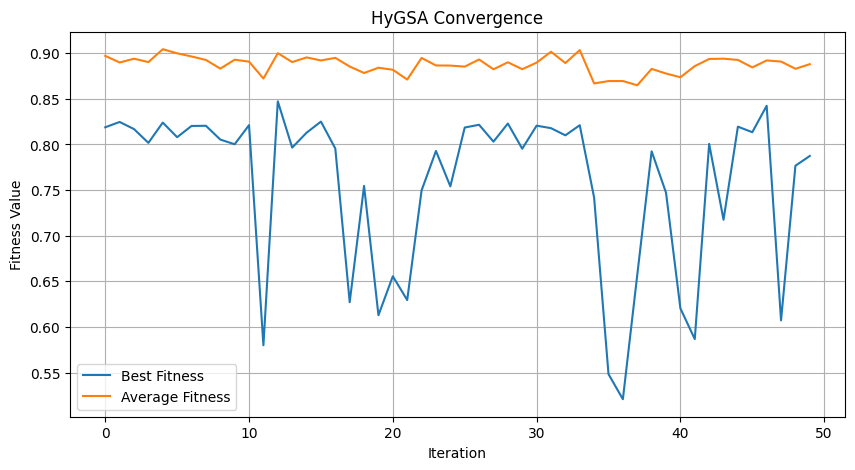

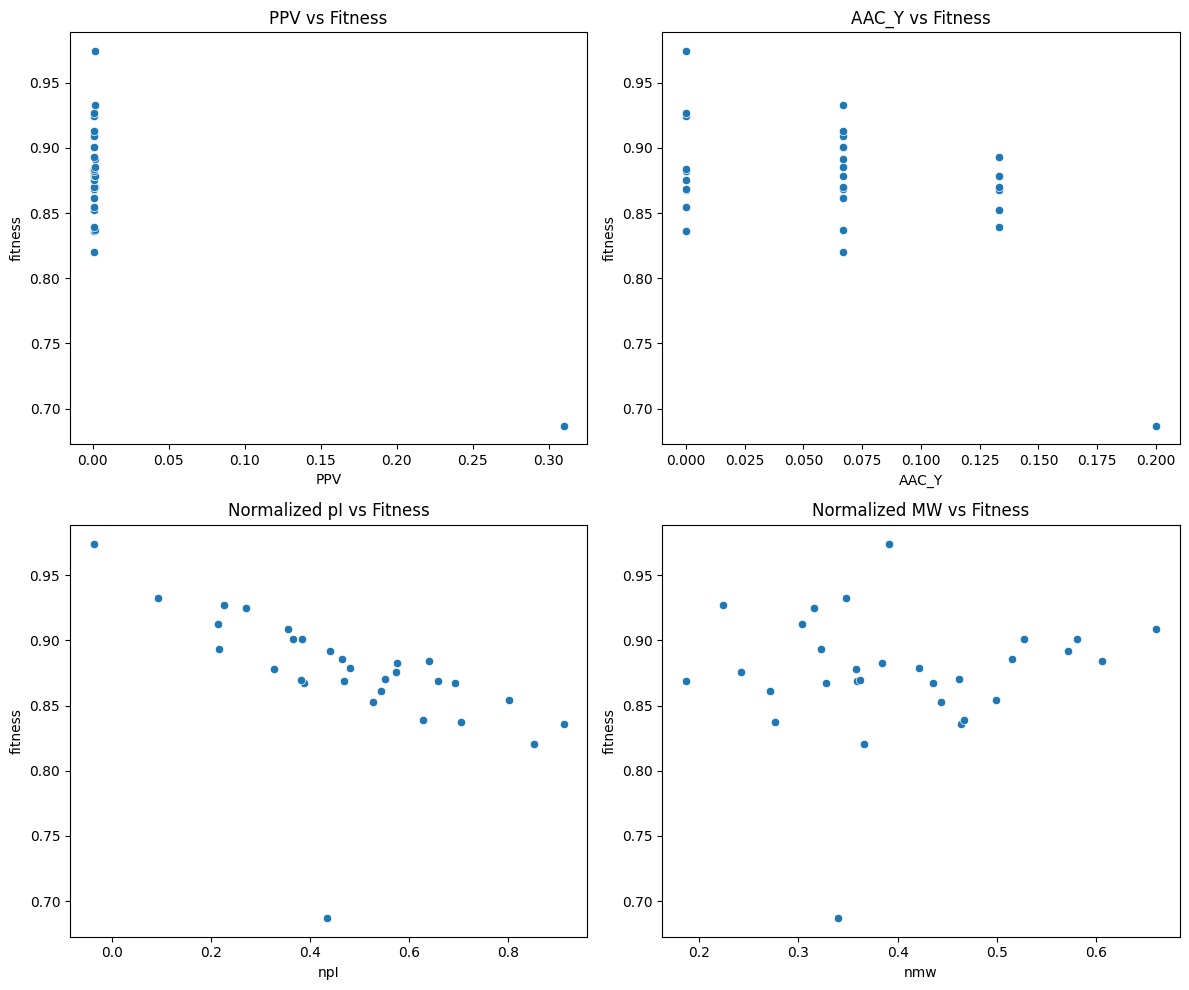

In [ ]:
# Initialize and run HyGSA
hygsa = HyGSA(model, num_particles=30, max_iter=50)
results, best_fit, avg_fit = hygsa.run()

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

# Display top 10 peptides
print("\nTop 10 Optimized Peptides:")
print(results_df.head(10)[['peptide', 'fitness', 'PPV', 'AAC_Y', 'npI', 'nmw']])

# Plot fitness convergence
plt.figure(figsize=(10, 5))
plt.plot(best_fit, label='Best Fitness')
plt.plot(avg_fit, label='Average Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness Value')
plt.title('HyGSA Convergence')
plt.legend()
plt.grid()
plt.show()

# Plot final population properties
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(data=results_df, x='PPV', y='fitness', ax=axes[0, 0])
axes[0, 0].set_title('PPV vs Fitness')

sns.scatterplot(data=results_df, x='AAC_Y', y='fitness', ax=axes[0, 1])
axes[0, 1].set_title('AAC_Y vs Fitness')

sns.scatterplot(data=results_df, x='npI', y='fitness', ax=axes[1, 0])
axes[1, 0].set_title('Normalized pI vs Fitness')

sns.scatterplot(data=results_df, x='nmw', y='fitness', ax=axes[1, 1])
axes[1, 1].set_title('Normalized MW vs Fitness')

plt.tight_layout()
plt.show()

# Interactive 3D plot of objectives
fig = px.scatter_3d(results_df, x='PPV', y='AAC_Y', z='npI',
                    color='fitness', hover_data=['peptide'],
                    title='Peptide Properties in 3D Space')
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create dashboard
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Fitness Convergence', 'PPV Distribution',
                                   'AAC_Y vs pI', 'Molecular Weight Distribution'))

# Fitness convergence
fig.add_trace(
    go.Scatter(x=list(range(len(best_fit))), y=best_fit, name='Best Fitness'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(len(avg_fit))), y=avg_fit, name='Avg Fitness'),
    row=1, col=1
)

# PPV distribution
fig.add_trace(
    go.Histogram(x=results_df['PPV'], nbinsx=20),
    row=1, col=2
)

# AAC_Y vs pI
fig.add_trace(
    go.Scatter(x=results_df['AAC_Y'], y=results_df['npI'], mode='markers',
               marker=dict(color=results_df['fitness'], colorscale='Viridis', showscale=True)),
    row=2, col=1
)

# MW distribution
fig.add_trace(
    go.Box(y=results_df['nmw'], name='Normalized MW'),
    row=2, col=2
)

fig.update_layout(height=800, width=1000, title_text="HyGSA Optimization Dashboard")
fig.show()